In [1]:
import pandas as pd
from tqdm import tqdm
from serenityff.charge.tree.dash_tree import DASHTree
from rdkit import Chem
import torch
# from custom_featurization_stuff import get_graph_from_mol
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt

allowable_set= ["C","N","O","F","P","S","Cl","Br","I","H"]

In [2]:
from tqdm import tqdm
# Function to read SDF file and extract properties
def read_sdf(file_path,prop_name,conditions = None):
    print(f'Reading {file_path}')
    try:
        suppl = Chem.SDMolSupplier(file_path)
        data = []
        for mol in tqdm(suppl):
            if mol is not None:
                smiles = Chem.MolToSmiles(mol)
                prop_val = float(mol.GetProp(f'{prop_name}')) if mol.HasProp(f'{prop_name}') else None
                data.append({'SMILES': smiles, prop_name: prop_val})
        return data
    except OSError:
        print(f'Error reading {file_path}')
        return None

# File paths for your SDF files
vp_path = 'OPERA_Data/VP_QR.sdf'
logp_path = 'OPERA_Data/LogP_QR.sdf'
aoh_path = 'OPERA_Data/AOH_QR.sdf'
bcf_path = 'OPERA_Data/BCF_QR.sdf'
biodeg_path = 'OPERA_Data/Biodeg_QR.sdf'
BP_path = 'OPERA_Data/BP_QR.sdf'
Clint_path = 'OPERA_Data/Clint_QR.sdf'
CoMPARA_path = 'OPERA_Data/CoMPARA_QR.sdf'
FU_path = 'OPERA_Data/FU_QR.sdf'
HL_path = 'OPERA_Data/HL_QR.sdf'
KM_path = 'OPERA_Data/KM_QR.sdf'
KOA_path = 'OPERA_Data/KOA_QR.sdf'
KOC_path = 'OPERA_Data/KOC_QR.sdf'
MP_path = 'OPERA_Data/MP_QR.sdf'
pKA_path = 'OPERA_Data/pKa_QR.sdf'
RBiodeg_path = 'OPERA_Data/RBiodeg_QR.sdf'
RT_path = 'OPERA_Data/RT_QR.sdf'
TR_path = 'OPERA_Data/TR_QR.sdf'
WS_path = 'OPERA_Data/WS_QR.sdf'


# Read SDF files and extract data
data_vp = read_sdf(vp_path, 'LogVP') #has temperature --> pick only one?
data_logp = read_sdf(logp_path, 'LogP')
data_aoh = read_sdf(aoh_path, 'LogOH')
data_bcf = read_sdf(bcf_path, 'LogBCF')
data_biodeg = read_sdf(biodeg_path, 'LogHalfLife')
data_BP = read_sdf(BP_path, 'BP')
data_Clint = read_sdf(Clint_path, 'Clint')
data_FU = read_sdf(FU_path, 'FU')
data_HL = read_sdf(HL_path, 'LogHL') #has temperature --> pick only one?
data_KM = read_sdf(KM_path, 'LogKmHL')
data_KOA = read_sdf(KOA_path, 'LogKOA')
data_KOC = read_sdf(KOC_path, 'LogKOC')
data_MP = read_sdf(MP_path, 'MP')
data_RT = read_sdf(RT_path, 'RT')
data_WS = read_sdf(WS_path, 'LogMolar') #has temperature --> pick only one?

#excluded:
# data_pKA = read_sdf(pKA_path, 'pKa')
# data_RBiodeg = read_sdf(RBiodeg_path, 'RBiodeg') binary
# data_CoMPARA = read_sdf(CoMPARA_path, 'CoMPARA')#contains a lot of different stuff, can take all or none or some, look at later
# data_CATMOS = read_sdf(CATMOS_path, 'CATMOS') #contains a lot of different stuff, can take all or none or some, look at later
# data_CERAPP = read_sdf(CERAPP_path, 'CERAPP')#contains a lot of different stuff, can take all or none or some, look at later


# Create Pandas dataframes
df_vp = pd.DataFrame(data_vp)
df_logp = pd.DataFrame(data_logp)
df_aoh = pd.DataFrame(data_aoh)
df_bcf = pd.DataFrame(data_bcf)
df_biodeg = pd.DataFrame(data_biodeg)
df_BP = pd.DataFrame(data_BP)
df_Clint = pd.DataFrame(data_Clint)
df_FU = pd.DataFrame(data_FU)
df_HL = pd.DataFrame(data_HL)
df_KM = pd.DataFrame(data_KM)
df_KOA = pd.DataFrame(data_KOA)
df_KOC = pd.DataFrame(data_KOC)
df_MP = pd.DataFrame(data_MP)
df_RT = pd.DataFrame(data_RT)
df_WS = pd.DataFrame(data_WS)

# Get the smiles for all dataframes
smiles_vp = df_vp['SMILES'].tolist()
smiles_logp = df_logp['SMILES'].tolist()
smiles_aoh = df_aoh['SMILES'].tolist()
smiles_bcf = df_bcf['SMILES'].tolist()
smiles_biodeg = df_biodeg['SMILES'].tolist()
smiles_BP = df_BP['SMILES'].tolist()
smiles_Clint = df_Clint['SMILES'].tolist()
smiles_FU = df_FU['SMILES'].tolist()
smiles_HL = df_HL['SMILES'].tolist()
smiles_KM = df_KM['SMILES'].tolist()
smiles_KOA = df_KOA['SMILES'].tolist()
smiles_KOC = df_KOC['SMILES'].tolist()
smiles_MP = df_MP['SMILES'].tolist()
smiles_RT = df_RT['SMILES'].tolist()
smiles_WS = df_WS['SMILES'].tolist()

# Get combined smiles
smiles_all = smiles_vp + smiles_logp + smiles_aoh + smiles_bcf + smiles_biodeg + smiles_BP + smiles_Clint  + smiles_FU + smiles_HL + smiles_KM + smiles_KOA + smiles_KOC + smiles_MP  + smiles_RT + smiles_WS
smiles_all = [s for s in smiles_all if s is not None]
smiles_all = list(set(smiles_all))



Reading OPERA_Data/VP_QR.sdf


100%|██████████| 2819/2819 [00:00<00:00, 7735.61it/s]


Reading OPERA_Data/LogP_QR.sdf


  0%|          | 0/13963 [00:00<?, ?it/s][13:45:32] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 12 22 23 24 25 26 27
[13:45:32] ERROR: Could not sanitize molecule ending on line 38202
[13:45:32] ERROR: Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 12 22 23 24 25 26 27
100%|██████████| 13963/13963 [00:02<00:00, 5924.48it/s]


Reading OPERA_Data/AOH_QR.sdf


100%|██████████| 692/692 [00:00<00:00, 10262.56it/s]


Reading OPERA_Data/BCF_QR.sdf


  0%|          | 0/626 [00:00<?, ?it/s][13:45:35] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 12 22 23 24 25 26 27
[13:45:35] ERROR: Could not sanitize molecule ending on line 5019
[13:45:35] ERROR: Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 12 22 23 24 25 26 27
100%|██████████| 626/626 [00:00<00:00, 6519.77it/s]


Reading OPERA_Data/Biodeg_QR.sdf


100%|██████████| 150/150 [00:00<00:00, 6528.30it/s]


Reading OPERA_Data/BP_QR.sdf


100%|██████████| 5434/5434 [00:00<00:00, 9474.06it/s]


Reading OPERA_Data/Clint_QR.sdf


100%|██████████| 551/551 [00:00<00:00, 5216.97it/s]


Reading OPERA_Data/FU_QR.sdf


100%|██████████| 1613/1613 [00:00<00:00, 4495.62it/s]


Reading OPERA_Data/HL_QR.sdf


100%|██████████| 697/697 [00:00<00:00, 7183.97it/s]


Reading OPERA_Data/KM_QR.sdf


100%|██████████| 541/541 [00:00<00:00, 6587.12it/s]


Reading OPERA_Data/KOA_QR.sdf


100%|██████████| 270/270 [00:00<00:00, 7851.62it/s]


Reading OPERA_Data/KOC_QR.sdf


100%|██████████| 728/728 [00:00<00:00, 6755.20it/s]


Reading OPERA_Data/MP_QR.sdf


  0%|          | 0/8698 [00:00<?, ?it/s][13:45:36] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 12 22 23 24 25 26 27
[13:45:36] ERROR: Could not sanitize molecule ending on line 52970
[13:45:36] ERROR: Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 12 22 23 24 25 26 27
100%|██████████| 8698/8698 [00:01<00:00, 7023.34it/s]


Reading OPERA_Data/RT_QR.sdf


100%|██████████| 97/97 [00:00<00:00, 5013.28it/s]


Reading OPERA_Data/WS_QR.sdf


100%|██████████| 5269/5269 [00:00<00:00, 6897.98it/s]


In [3]:
logP = []
logVP = []
logOH = []
logBCF = []
Biodeg = []
BP = []
Clint = []
FU = []
HL = []
KM = []
KOA = []
KOC = []
MP = []
RT = []
WS = []

for smile in tqdm(smiles_all):
    logP.append(df_logp[df_logp['SMILES'] == smile]['LogP'].values[0] if smile in smiles_logp else 0.0)
    logVP.append(df_vp[df_vp['SMILES'] == smile]['LogVP'].values[0] if smile in smiles_vp else 0.0)
    logOH.append(df_aoh[df_aoh['SMILES'] == smile]['LogOH'].values[0] if smile in smiles_aoh else 0.0)
    logBCF.append(df_bcf[df_bcf['SMILES'] == smile]['LogBCF'].values[0] if smile in smiles_bcf else 0.0)
    Biodeg.append(df_biodeg[df_biodeg['SMILES'] == smile]['LogHalfLife'].values[0] if smile in smiles_biodeg else 0.0)
    BP.append(df_BP[df_BP['SMILES'] == smile]['BP'].values[0] if smile in smiles_BP else 0.0)
    Clint.append(df_Clint[df_Clint['SMILES'] == smile]['Clint'].values[0] if smile in smiles_Clint else 0.0)
    FU.append(df_FU[df_FU['SMILES'] == smile]['FU'].values[0] if smile in smiles_FU else 0.0)
    HL.append(df_HL[df_HL['SMILES'] == smile]['LogHL'].values[0] if smile in smiles_HL else 0.0)
    KM.append(df_KM[df_KM['SMILES'] == smile]['LogKmHL'].values[0] if smile in smiles_KM else 0.0)
    KOA.append(df_KOA[df_KOA['SMILES'] == smile]['LogKOA'].values[0] if smile in smiles_KOA else 0.0)
    KOC.append(df_KOC[df_KOC['SMILES'] == smile]['LogKOC'].values[0] if smile in smiles_KOC else 0.0)
    MP.append(df_MP[df_MP['SMILES'] == smile]['MP'].values[0] if smile in smiles_MP else 0.0)
    RT.append(df_RT[df_RT['SMILES'] == smile]['RT'].values[0] if smile in smiles_RT else 0.0)
    WS.append(df_WS[df_WS['SMILES'] == smile]['LogMolar'].values[0] if smile in smiles_WS else 0.0)


# Make a new dataframe
df = pd.DataFrame({'SMILES': smiles_all, 'logP': logP, 'logVP': logVP, 'logOH': logOH, 'logBCF': logBCF, 'Biodeg': Biodeg, 'BP': BP,'Clint': Clint, 'FU': FU, 'HL': HL, 'KM': KM, 'KOA': KOA, 'KOC': KOC, 'MP': MP, 'RT': RT, 'WS': WS})
df


100%|██████████| 23256/23256 [00:23<00:00, 992.77it/s] 


,SMILES,logP,logVP,logOH,logBCF,Biodeg,BP,Clint,FU,HL,KM,KOA,KOC,MP,RT,WS
0,CN(C)C(=O)Nc1ccc(Oc2nnn(C(C)(C)C)n2)cc1,2.08,0.0000,0.000000,0.00,0.0,0.0,0.0,0.0,0.000000,0.00,0.00,0.00,0.0,0.0,0.000000
1,CC(C)C1CCC(=NO)C(=NO)C1,0.00,0.0000,0.000000,0.00,0.0,0.0,0.0,0.0,0.000000,0.00,0.00,0.00,0.0,0.0,-2.390300
2,Brc1ccc(Oc2ccc(Br)c(Br)c2Br)c(Br)c1,7.37,-8.1427,0.000000,0.00,0.0,0.0,0.0,0.0,0.000000,1.34,11.66,0.00,0.0,0.0,0.000000
3,Cc1ccc(C)n1Nc1ccc(N(CC(C)O)CC(C)O)nn1,1.55,0.0000,0.000000,0.00,0.0,0.0,0.0,0.0,0.000000,0.00,0.00,0.00,0.0,0.0,0.000000
4,O=C(O)c1cc([N+](=O)[O-])cc([N+](=O)[O-])c1,1.55,0.0000,0.000000,0.00,0.0,0.0,0.0,0.0,0.000000,0.00,0.00,1.53,205.0,0.0,-2.198085
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23251,O=C(c1ccccc1)C1CCCCC1,0.00,0.0000,0.000000,0.00,0.0,0.0,0.0,0.0,0.000000,0.00,0.00,0.00,56.0,0.0,0.000000
23252,c1ccsc1,1.85,1.9013,-11.020907,0.95,0.0,84.0,0.0,0.0,-2.643974,-0.82,0.00,0.00,-39.4,0.0,-1.419043
23253,CNC(=O)Oc1cccc(C(C)C)c1,2.63,0.0000,0.000000,0.00,0.0,0.0,0.0,0.0,0.000000,0.00,0.00,0.00,73.0,0.0,-3.356700
23254,CC(C)CCOC(=O)CC(C)C,0.00,-0.0526,0.000000,0.00,0.0,190.4,0.0,0.0,0.000000,0.00,0.00,0.00,0.0,0.0,0.000000


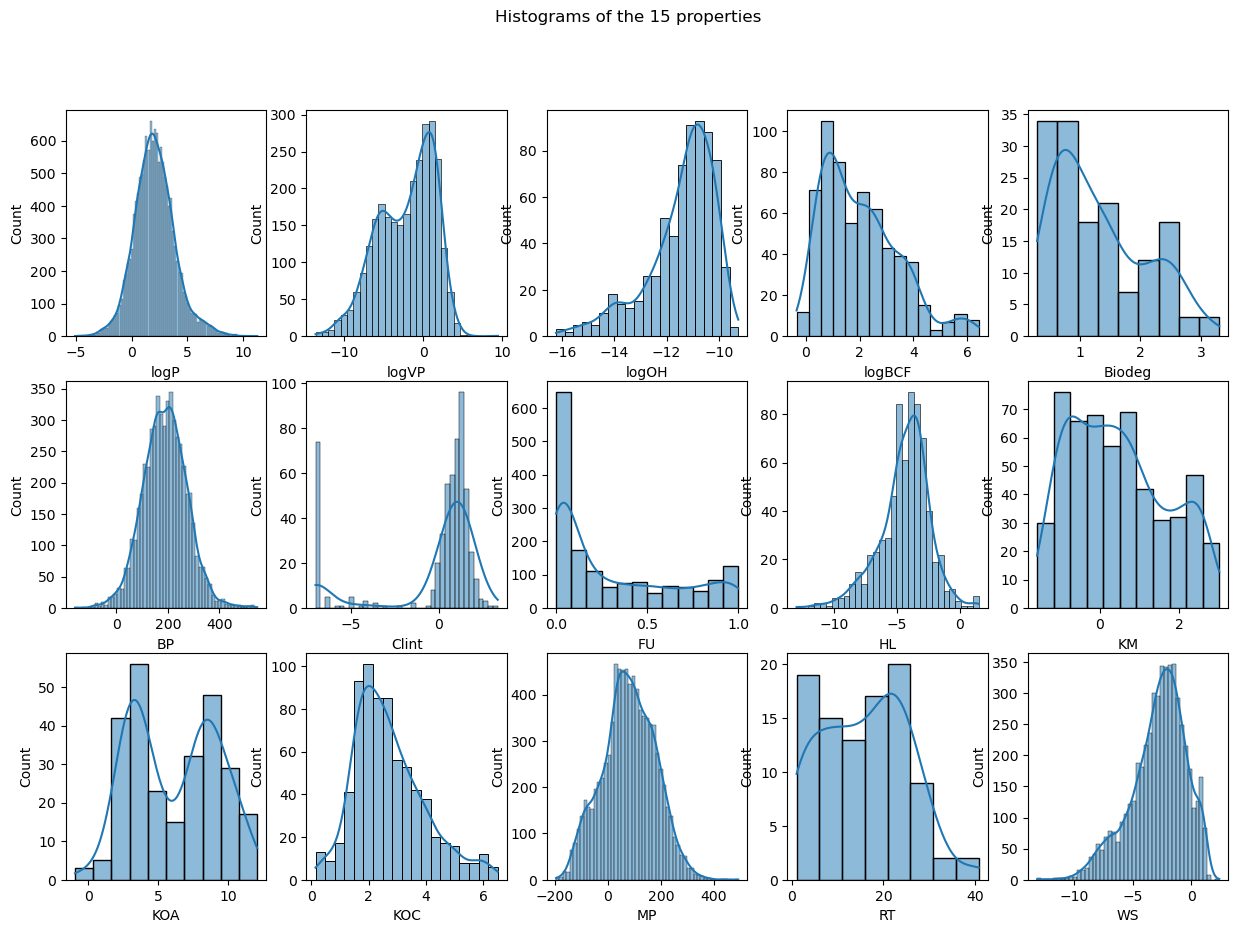

In [4]:
#make copy with 0.0 --> NaN
df_nan = df.copy()
df_nan = df_nan.replace(0.0, float('nan'))
#do histograms (3x5) of the 15 properties
fig, axes = plt.subplots(3, 5, figsize=(15, 10))
fig.suptitle('Histograms of the 15 properties')
sns.histplot(df_nan['logP'], kde=True, ax=axes[0, 0])
sns.histplot(df_nan['logVP'], kde=True, ax=axes[0, 1])
sns.histplot(df_nan['logOH'], kde=True, ax=axes[0, 2])
sns.histplot(df_nan['logBCF'], kde=True, ax=axes[0, 3])
sns.histplot(df_nan['Biodeg'], kde=True, ax=axes[0, 4])
sns.histplot(df_nan['BP'], kde=True, ax=axes[1, 0])
sns.histplot(df_nan['Clint'], kde=True, ax=axes[1, 1])
sns.histplot(df_nan['FU'], kde=True, ax=axes[1, 2])
sns.histplot(df_nan['HL'], kde=True, ax=axes[1, 3])
sns.histplot(df_nan['KM'], kde=True, ax=axes[1, 4])
sns.histplot(df_nan['KOA'], kde=True, ax=axes[2, 0])
sns.histplot(df_nan['KOC'], kde=True, ax=axes[2, 1])
sns.histplot(df_nan['MP'], kde=True, ax=axes[2, 2])
sns.histplot(df_nan['RT'], kde=True, ax=axes[2, 3])
sns.histplot(df_nan['WS'], kde=True, ax=axes[2, 4])
plt.show()

<Axes: xlabel='WS', ylabel='Count'>

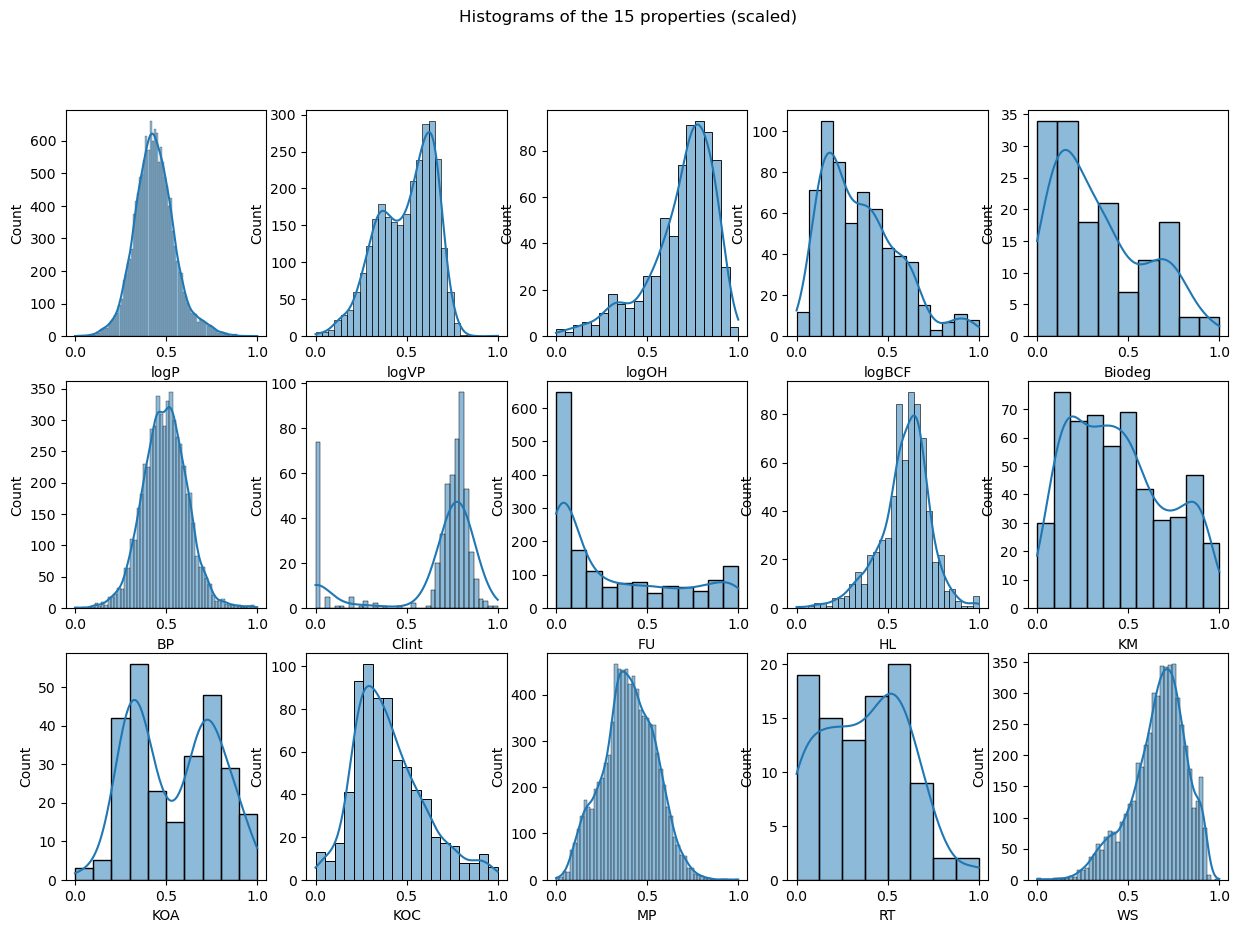

In [5]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_scaled = df_nan.copy()
df_scaled[['logP', 'logVP', 'logOH', 'logBCF', 'Biodeg', 'BP', 'Clint', 'FU', 'HL', 'KM', 'KOA', 'KOC', 'MP', 'RT', 'WS']] = scaler.fit_transform(df_scaled[['logP', 'logVP', 'logOH', 'logBCF', 'Biodeg', 'BP', 'Clint', 'FU', 'HL', 'KM', 'KOA', 'KOC', 'MP', 'RT', 'WS']])
df_scaled
#plot
fig, axes = plt.subplots(3, 5, figsize=(15, 10))
fig.suptitle('Histograms of the 15 properties (scaled)')
sns.histplot(df_scaled['logP'], kde=True, ax=axes[0, 0])
sns.histplot(df_scaled['logVP'], kde=True, ax=axes[0, 1])
sns.histplot(df_scaled['logOH'], kde=True, ax=axes[0, 2])
sns.histplot(df_scaled['logBCF'], kde=True, ax=axes[0, 3])
sns.histplot(df_scaled['Biodeg'], kde=True, ax=axes[0, 4])
sns.histplot(df_scaled['BP'], kde=True, ax=axes[1, 0])
sns.histplot(df_scaled['Clint'], kde=True, ax=axes[1, 1])
sns.histplot(df_scaled['FU'], kde=True, ax=axes[1, 2])
sns.histplot(df_scaled['HL'], kde=True, ax=axes[1, 3])
sns.histplot(df_scaled['KM'], kde=True, ax=axes[1, 4])
sns.histplot(df_scaled['KOA'], kde=True, ax=axes[2, 0])
sns.histplot(df_scaled['KOC'], kde=True, ax=axes[2, 1])
sns.histplot(df_scaled['MP'], kde=True, ax=axes[2, 2])
sns.histplot(df_scaled['RT'], kde=True, ax=axes[2, 3])
sns.histplot(df_scaled['WS'], kde=True, ax=axes[2, 4])

In [55]:
#split check: if we do a random split 80/20, do we also get a 80/20 split for each property?
train, test = train_test_split(df_scaled, test_size=0.2, random_state=42)
#for each property, check if the split is 80/20
for col in df_scaled.columns[1:]:
    print(f'{col}: {test[col].count()/df_scaled[col].count()}')
    print('')

logP: 0.19846396784381282

logVP: 0.20618556701030927

logOH: 0.20520231213872833

logBCF: 0.22347266881028938

Biodeg: 0.21333333333333335

BP: 0.19182621502209132

Clint: 0.19152854511970535

FU: 0.20240354206198607

HL: 0.2152080344332855

KM: 0.23290203327171904

KOA: 0.21851851851851853

KOC: 0.2152777777777778

MP: 0.20046323103647945

RT: 0.21649484536082475

WS: 0.20521672420406598



In [11]:
# tree = DASHTree(tree_folder_path='/localhome/cschiebroek/other/serenityff-charge/tree')

Loading DASH tree data


In [12]:
# all_mols = [Chem.MolFromSmiles(smi) for smi in df['SMILES']]
# mols = [m for m in all_mols if m.GetNumAtoms() > 1]
# error_mol = [m for m in all_mols if m.GetNumAtoms() <= 1]
# mols_with_charges = []
# error_mols_charges = []
# for m in tqdm(mols):
#     try:
#         mol = Chem.AddHs(m, addCoords=True)
#         charges = tree.get_molecules_partial_charges(mol,chg_std_key='std',chg_key='result')["charges"]
#     except:
#         error_mols_charges.append(m)
#         continue
#     for i,atom in enumerate(mol.GetAtoms()):
#         atom.SetDoubleProp('charge',charges[i])
#     mols_with_charges.append(mol)


100%|██████████| 15079/15079 [05:28<00:00, 45.88it/s]


In [13]:
# indices_to_drop_size = [all_mols.index(m) for m in error_mol]
# indices_to_drop_charges = [all_mols.index(m) for m in error_mols_charges]
# indices_to_drop_total = list(set(indices_to_drop_size + indices_to_drop_charges))
# print(len(indices_to_drop_total), len(indices_to_drop_size), len(indices_to_drop_charges))

143 1 142


In [15]:
# if indices_to_drop_total:
#     print('Caution! Mols dropped')
#     df = df.drop(indices_to_drop_total)

In [18]:
# #set values of second two columns as floats
# df['logP'] = df['logP'].astype(float)
# df['logVP'] = df['logVP'].astype(float)

In [6]:
from serenityff.charge.gnn.utils import get_graph_from_mol
import numpy as np
all_mols = [Chem.MolFromSmiles(smi) for smi in df_scaled['SMILES']]
mols = [m for m in all_mols if m.GetNumAtoms() > 1]
error_mol = [m for m in all_mols if m.GetNumAtoms() <= 1]
indices_to_drop_size = [all_mols.index(m) for m in error_mol]
if indices_to_drop_size:
    print(f'Caution! {len(indices_to_drop_size)} Mols dropped')
    df_scaled_size = df_scaled.drop(indices_to_drop_size)
ys = df_scaled_size.iloc[:, 1:].values
#change all nan to np.nan
ys = np.nan_to_num(ys, nan=-1)
y = torch.tensor(ys, dtype=torch.float32)
y = y.unsqueeze(1)
print(y[0])


Caution! 1 Mols dropped
tensor([[ 0.4374, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000]])


In [7]:
assert len(mols) == len(y)
mol_graphs = [get_graph_from_mol(mol,i, allowable_set,no_y=True) for i,mol in enumerate(mols)]

In [8]:
SMILES = df_scaled_size['SMILES'].tolist()
assert len(mol_graphs) == len(y) == len(SMILES)
for i in range(len(mol_graphs)):
    mol_graphs[i].SMILES = SMILES[i]
    mol_graphs[i].y = y[i]

In [47]:
#basics
import os
from math import sqrt
import pandas
import numpy as np
import random


#torch stuff
import torch
from torch.nn import functional as F
from torch.optim.lr_scheduler import ExponentialLR, ReduceLROnPlateau
from torch.nn.utils import clip_grad_norm_
from torch_geometric.nn.models import AttentiveFP
from torch_geometric.loader import DataLoader



device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#set random seeds
torch.manual_seed(0)
torch.cuda.manual_seed(0)
random.seed(0)
np.random.seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.use_deterministic_algorithms(False)

def train_multi(train_loader, model, optimizer, device, outputs):
    total_loss = total_examples = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.edge_attr, data.batch)
        weighted_loss = num_labels = 0
        for i in range(outputs):
            y_tmp = data.y[:, i]
            out_tmp = out[:, i]
            # Find indices where labels are available
            present_label_indices = torch.nonzero(y_tmp != -1).view(-1)
            num_labels += len(present_label_indices)

            if len(present_label_indices) > 0:
                # Extract only the available label indices
                out_tmp_present = torch.index_select(out_tmp, 0, present_label_indices)
                y_tmp_present = torch.index_select(y_tmp, 0, present_label_indices)

                # Calculate MSE loss only for available labels
                loss_tmp_present = F.mse_loss(out_tmp_present, y_tmp_present)
                if not torch.isnan(loss_tmp_present):
                    weighted_loss += loss_tmp_present * len(present_label_indices)

        weighted_loss = weighted_loss / num_labels
        weighted_loss.backward()

        total_loss += float(weighted_loss) * data.num_graphs
        total_examples += data.num_graphs

        # clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        del data

    return sqrt(total_loss / total_examples)


def validate_multi(val_loader, model, outputs):
    total_loss = total_examples = 0
    for data in val_loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.edge_attr, data.batch)
        weighted_loss = num_labels = 0
        for i in range(outputs):

            y_tmp = data.y[:, i]
            out_tmp = out[:, i]
            # Find indices where labels are available
            present_label_indices = torch.nonzero(y_tmp != -1).view(-1)
            num_labels += len(present_label_indices)

            if len(present_label_indices) > 0:
                # Extract only the available label indices
                out_tmp_present = torch.index_select(out_tmp, 0, present_label_indices)
                y_tmp_present = torch.index_select(y_tmp, 0, present_label_indices)

                # Calculate MSE loss only for available labels
                loss_tmp_present = F.mse_loss(out_tmp_present, y_tmp_present)
                if not torch.isnan(loss_tmp_present):
                    weighted_loss += loss_tmp_present * len(present_label_indices)

        weighted_loss = weighted_loss / num_labels

        total_loss += float(weighted_loss) * data.num_graphs
        total_examples += data.num_graphs
        del data

    return sqrt(total_loss / total_examples)

def train_and_validate_multi(model, train_loader, val_loader, optimizer, num_epochs, outputs, verbose=True):
    train_losses = []
    val_losses = []
    scheduler = ReduceLROnPlateau(optimizer, patience=2, factor=0.9,verbose=False)

    min_val_los = 10000000
    for epoch in range(num_epochs):
        model.train()
        train_loss = train_multi(train_loader, model, optimizer, device, outputs)
        train_losses.append(train_loss)

        model.eval()
        val_loss = validate_multi(val_loader, model, outputs)
        val_losses.append(val_loss)
        scheduler.step(val_loss)

        if val_loss < min_val_los:
            min_val_los = val_loss
            counter = 0
            torch.save(model.state_dict(), 'test_model.pt')

        else:
            counter += 1
        if counter > 10:
            if verbose:
                print('early stopping')
            break
        if verbose:
            print(f"Epoch {epoch + 1}/{num_epochs}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

In [52]:
outputs = 15
torch.cuda.empty_cache()
train_data, test_data = train_test_split(mol_graphs, test_size=0.2, random_state=0)
#split train in train and val
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=0)
# #datloaders
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)

model= AttentiveFP(in_channels=23, hidden_channels=200, out_channels=outputs,
                            edge_dim=11, num_layers=4, num_timesteps=2,
                            dropout=0.0).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=10**-3,
                        weight_decay=10**-4)
print(len(train_data), len(val_data), len(test_data))
# train_and_validate_multi(model, train_loader, val_loader, optimizer, num_epochs=100, outputs=outputs, verbose=True)

14883 3721 4651


In [ ]:
#save train and test data as .pt files
torch.save(train_data, 'train_data.pt')
torch.save(test_data, 'test_data.pt')

In [24]:
from scipy.stats import spearmanr,kendalltau

def get_preds_per_task(val_loader, model, outputs):
    preds = tuple([[] for i in range(outputs)])
    ys = tuple([[] for i in range(outputs)])
    counter = 0

    for data in val_loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.edge_attr, data.batch)
        
        for i in range(outputs):
            y_tmp = data.y[:, i]
            out_tmp = out[:, i]
            # Find indices where labels are available
            present_label_indices = torch.nonzero(y_tmp != -1).view(-1)

            counter += len(present_label_indices)

            # Create arrays with -1 values for indices not in present_label_indices
            preds_tmp = torch.full_like(y_tmp, -1)
            ys_tmp = torch.full_like(y_tmp, -1)

            if len(present_label_indices) > 0:
                # Replace -1 values with predictions and true values where available
                preds_tmp[present_label_indices] = out_tmp[present_label_indices]
                ys_tmp[present_label_indices] = y_tmp[present_label_indices]

            preds[i].extend(preds_tmp.detach().cpu().numpy().tolist())
            ys[i].extend(ys_tmp.detach().cpu().numpy().tolist())

    print(counter)
    return preds, ys



def get_stats(out_list,y_list):
    kendall_tau = kendalltau(y_list, out_list)[0]
    rmse_overall = np.sqrt(np.mean((np.array(y_list) - np.array(out_list)) ** 2))
    mae_overall = np.mean(np.abs(np.array(y_list) - np.array(out_list)))
    within_03_overall = np.mean(np.abs(np.array(y_list) - np.array(out_list)) < 0.3)
    within_1_overall = np.mean(np.abs(np.array(y_list) - np.array(out_list)) < 1)

    return kendall_tau,rmse_overall,mae_overall,within_03_overall,within_1_overall



In [49]:
#look at prediction on validation data
model= AttentiveFP(in_channels=23, hidden_channels=200, out_channels=outputs,
                            edge_dim=11, num_layers=4, num_timesteps=2,
                            dropout=0.0).to(device)
model.load_state_dict(torch.load('test_model.pt'))
model.to(device)
model.eval()
preds, ys = get_preds_per_task(val_loader = val_loader, model = model, outputs = outputs)

6773


In [50]:
#make df from preds
df_preds = pd.DataFrame(preds).T
df_preds.columns = df_scaled.columns[1:]
df_preds = df_preds.replace(-1, float('nan'))
df_preds[['logP', 'logVP', 'logOH', 'logBCF', 'Biodeg', 'BP', 'Clint', 'FU', 'HL', 'KM', 'KOA', 'KOC', 'MP', 'RT', 'WS']] = scaler.inverse_transform(df_preds[['logP', 'logVP', 'logOH', 'logBCF', 'Biodeg', 'BP', 'Clint', 'FU', 'HL', 'KM', 'KOA', 'KOC', 'MP', 'RT', 'WS']])
df_ys = pd.DataFrame(ys).T
df_ys.columns = df_scaled.columns[1:]
df_ys = df_ys.replace(-1, float('nan'))
df_ys[['logP', 'logVP', 'logOH', 'logBCF', 'Biodeg', 'BP', 'Clint', 'FU', 'HL', 'KM', 'KOA', 'KOC', 'MP', 'RT', 'WS']] = scaler.inverse_transform(df_ys[['logP', 'logVP', 'logOH', 'logBCF', 'Biodeg', 'BP', 'Clint', 'FU', 'HL', 'KM', 'KOA', 'KOC', 'MP', 'RT', 'WS']])
df_ys

,logP,logVP,logOH,logBCF,Biodeg,BP,Clint,FU,HL,KM,KOA,KOC,MP,RT,WS
0,NaN,NaN,NaN,NaN,NaN,227.00002,NaN,NaN,NaN,NaN,NaN,NaN,-36.699999,NaN,-3.800512
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.697799
2,1.42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5.23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,214.499985,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3716,-1.22,NaN,NaN,NaN,NaN,NaN,NaN,0.95,NaN,NaN,NaN,NaN,NaN,NaN,-0.621201
3717,4.47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3718,3.49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3719,NaN,3.975097,NaN,NaN,NaN,105.89999,NaN,NaN,NaN,NaN,NaN,NaN,-46.933338,NaN,NaN


Property: logP
kendall_tau: 0.4044812886254145
rmse_overall: 1.4693316091936819
mae_overall: 1.1219588714867292
within_03_overall: 0.17177097203728361
within_1_overall: 0.5579227696404794
R2: 0.3567957082099503
Pearson: 0.6236264563983338


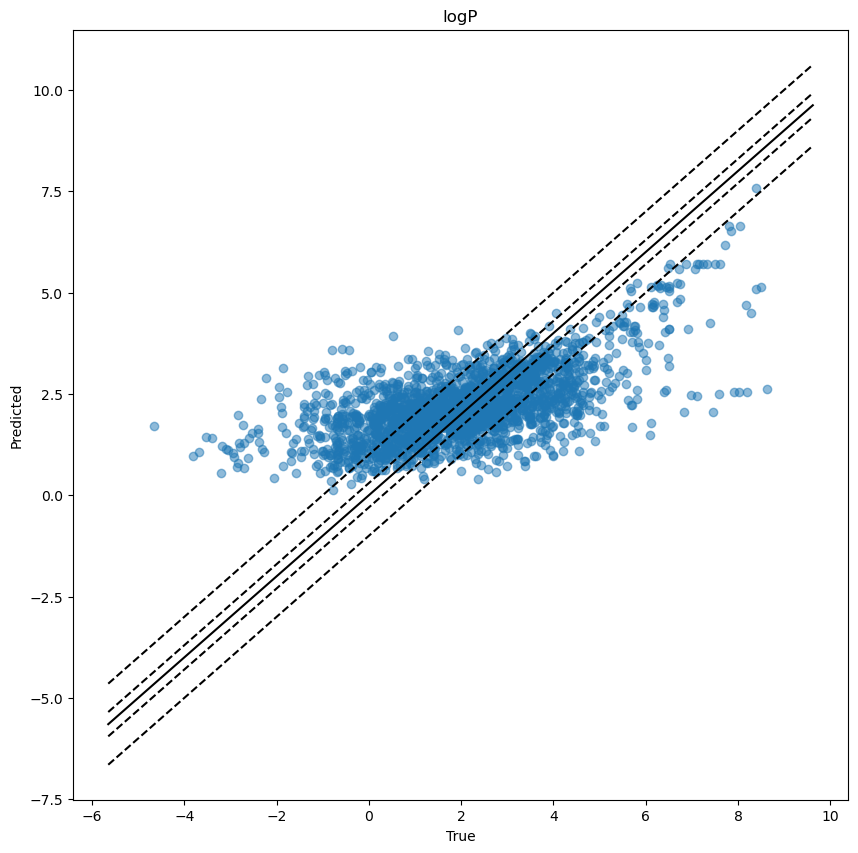

Property: logVP
kendall_tau: 0.6846027785709022
rmse_overall: 2.0691994241104377
mae_overall: 1.548203335959017
within_03_overall: 0.13852813852813853
within_1_overall: 0.40476190476190477
R2: 0.6736774863012829
Pearson: 0.8352798054765092


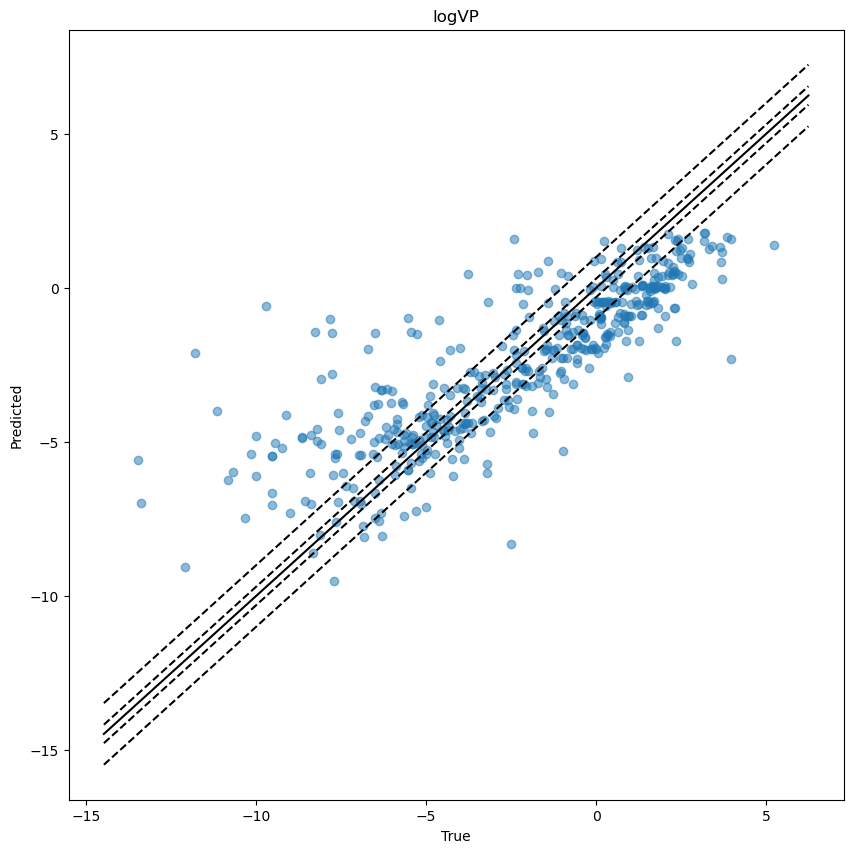

Property: logOH
kendall_tau: 0.19263375805049407
rmse_overall: 1.2628393386055878
mae_overall: 0.9760824438387706
within_03_overall: 0.15966386554621848
within_1_overall: 0.5966386554621849
R2: 0.04815825802263374
Pearson: 0.26328553027852536


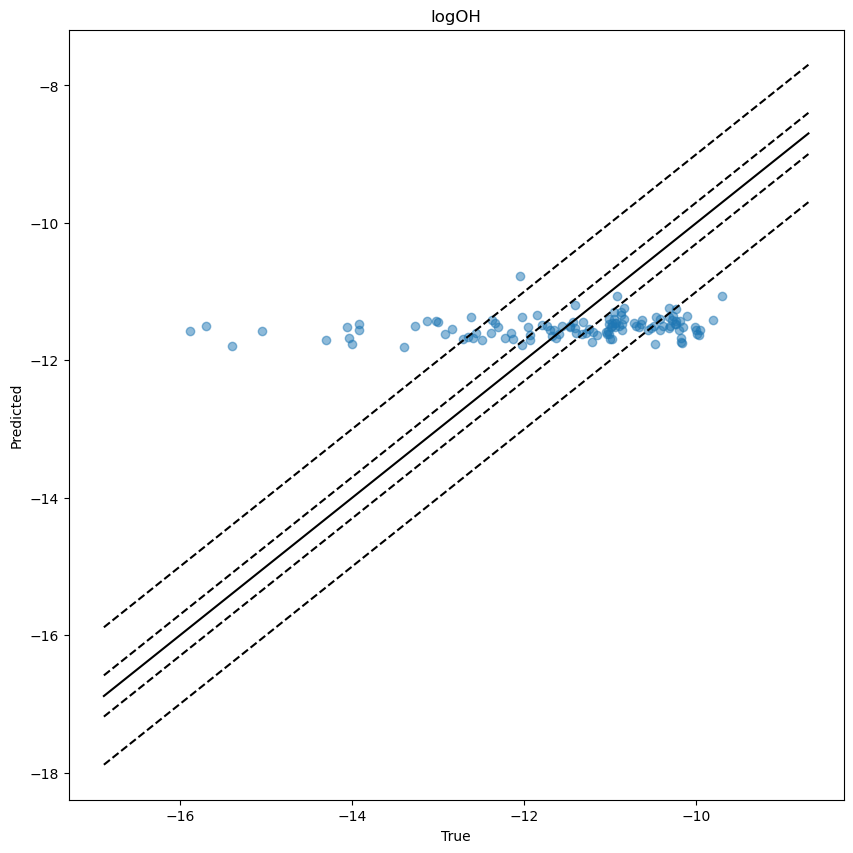

Property: logBCF
kendall_tau: 0.3562728112935785
rmse_overall: 1.2446101957367877
mae_overall: 1.0167564577830488
within_03_overall: 0.15625
within_1_overall: 0.5833333333333334
R2: 0.23907188173671934
Pearson: 0.575436244022798


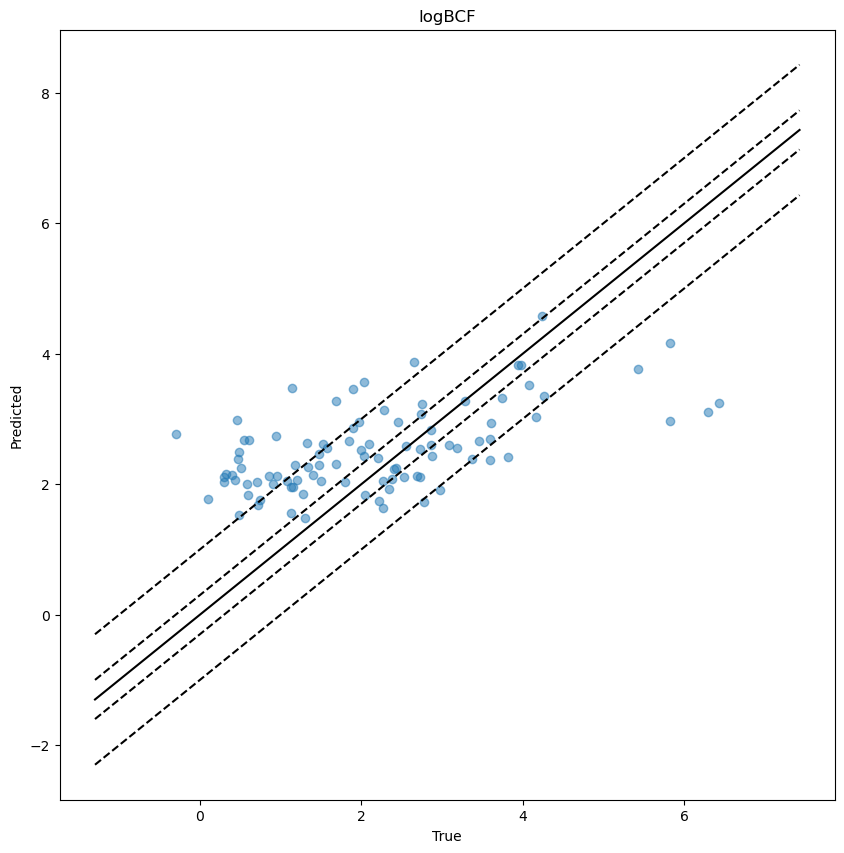

Property: Biodeg
kendall_tau: 0.15988217546179165
rmse_overall: 0.44263531596099615
mae_overall: 0.32616249232419897
within_03_overall: 0.5714285714285714
within_1_overall: 0.9642857142857143
R2: 0.3317933901714668
Pearson: 0.5979515173329807


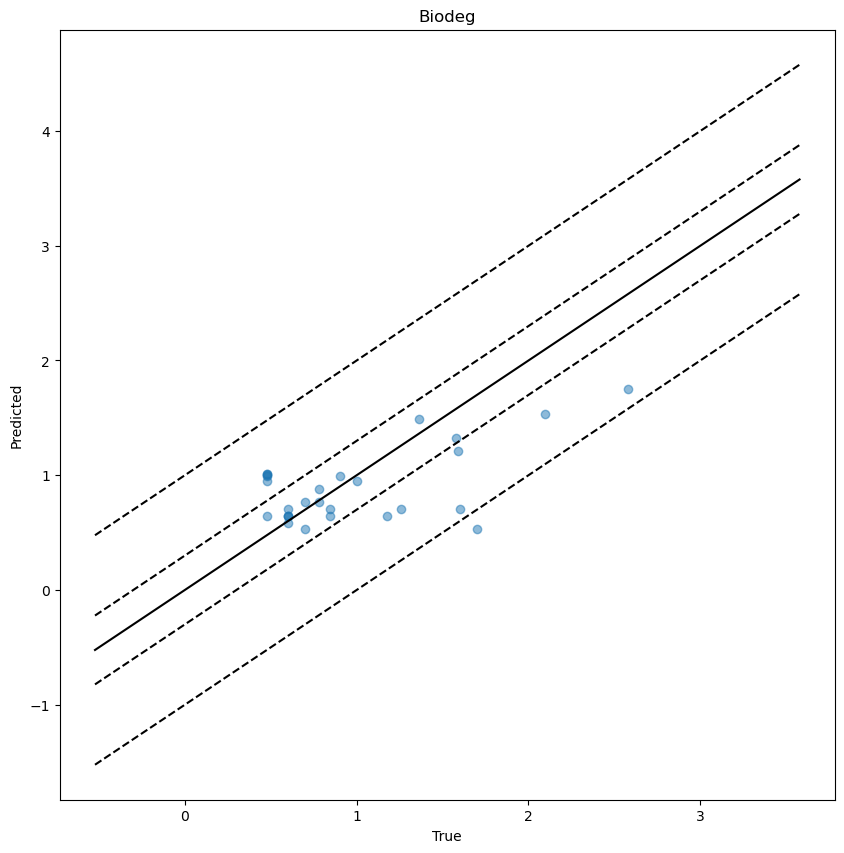

Property: BP
kendall_tau: 0.6368971939024269
rmse_overall: 50.15733003769423
mae_overall: 37.42562595947008
within_03_overall: 0.007017543859649123
within_1_overall: 0.014035087719298246
R2: 0.6569316023121089
Pearson: 0.8182601273222971


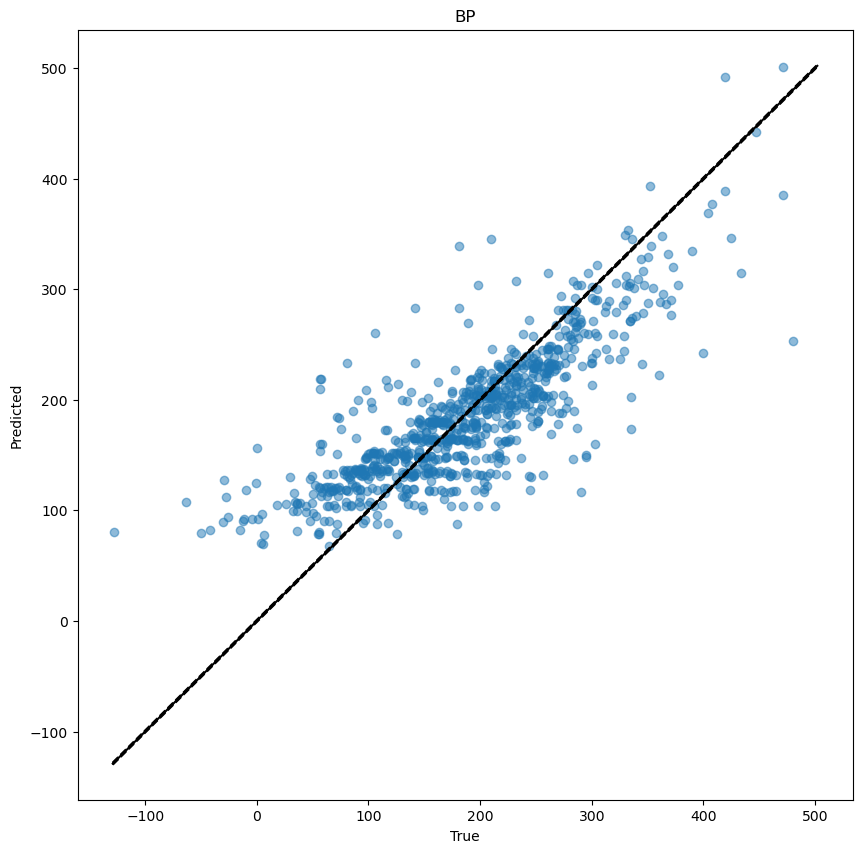

Property: Clint
kendall_tau: -0.052051575934671114
rmse_overall: 3.2235141010231585
mae_overall: 2.729126580871384
within_03_overall: 0.0
within_1_overall: 0.0784313725490196
R2: -0.01308316226415518
Pearson: -0.09861322921602042


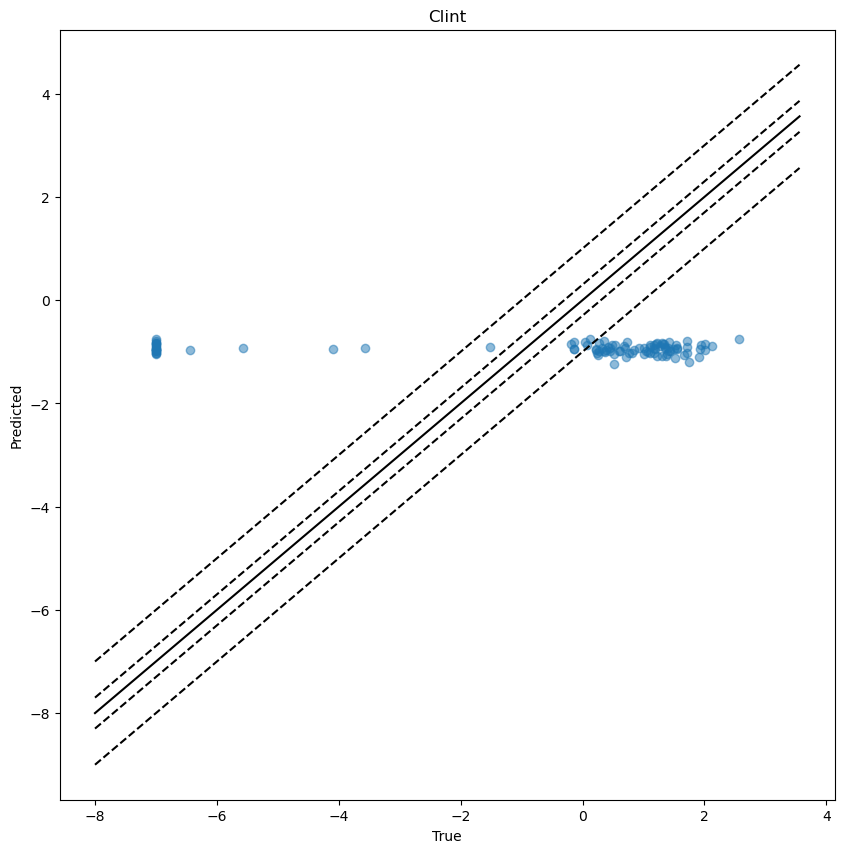

Property: FU
kendall_tau: 0.2450904819766582
rmse_overall: 0.3138637327129103
mae_overall: 0.25781977264081823
within_03_overall: 0.7051792828685259
within_1_overall: 1.0
R2: 0.12507700237152908
Pearson: 0.4018135636976857


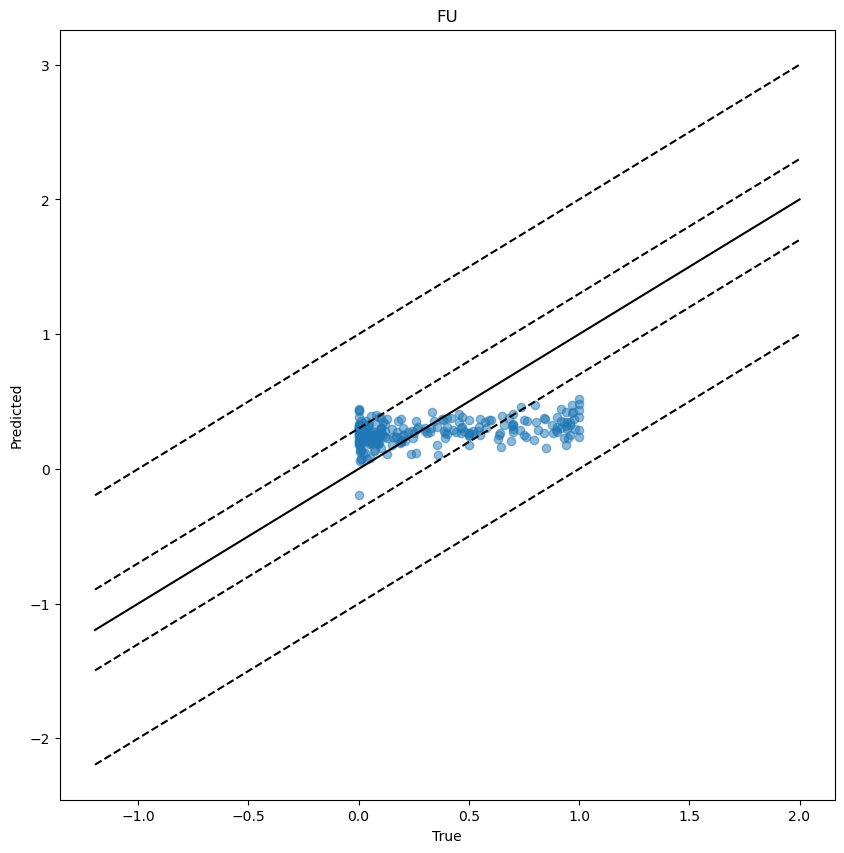

Property: HL
kendall_tau: 0.15289413833888071
rmse_overall: 2.374296615944223
mae_overall: 1.8417863160543873
within_03_overall: 0.0970873786407767
within_1_overall: 0.34951456310679613
R2: -0.2820802563355187
Pearson: 0.2606631569526797


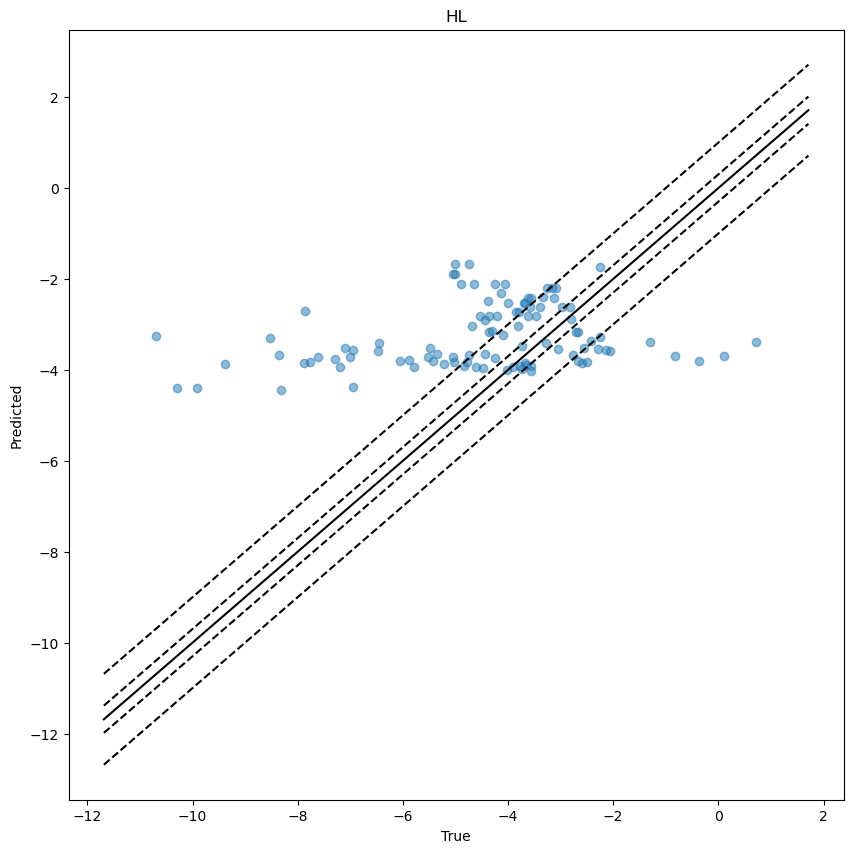

Property: KM
kendall_tau: 0.38482630600497125
rmse_overall: 1.0606111242547716
mae_overall: 0.9227217224569514
within_03_overall: 0.18604651162790697
within_1_overall: 0.5465116279069767
R2: 0.28839263998930653
Pearson: 0.5764544634569012


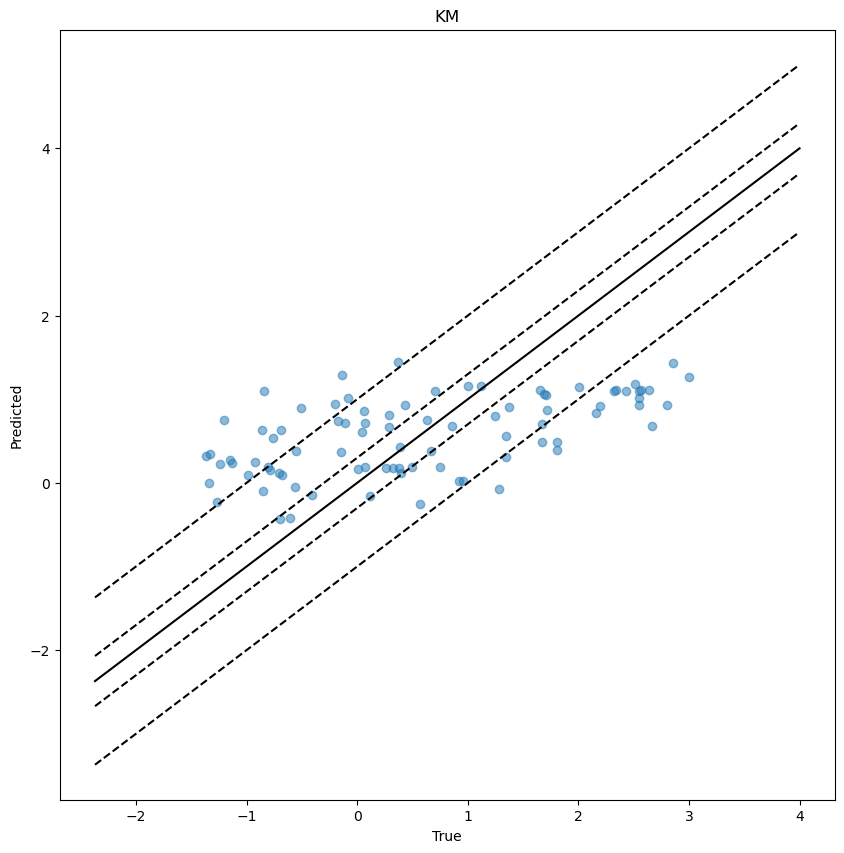

Property: KOA
kendall_tau: 0.732985409430735
rmse_overall: 1.3090770582351035
mae_overall: 1.0305957040510008
within_03_overall: 0.14285714285714285
within_1_overall: 0.6190476190476191
R2: 0.8277897837750325
Pearson: 0.9259830507023032


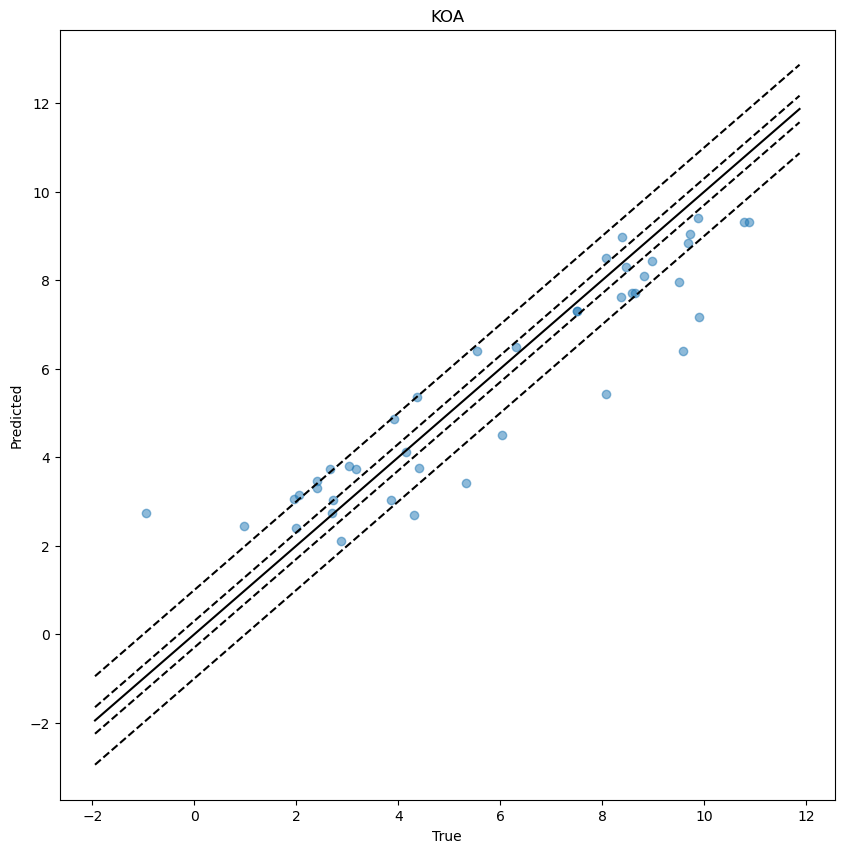

Property: KOC
kendall_tau: 0.5607169116290789
rmse_overall: 0.8766714416612719
mae_overall: 0.688316793019246
within_03_overall: 0.2807017543859649
within_1_overall: 0.7807017543859649
R2: 0.5447692874422434
Pearson: 0.7874160848821584


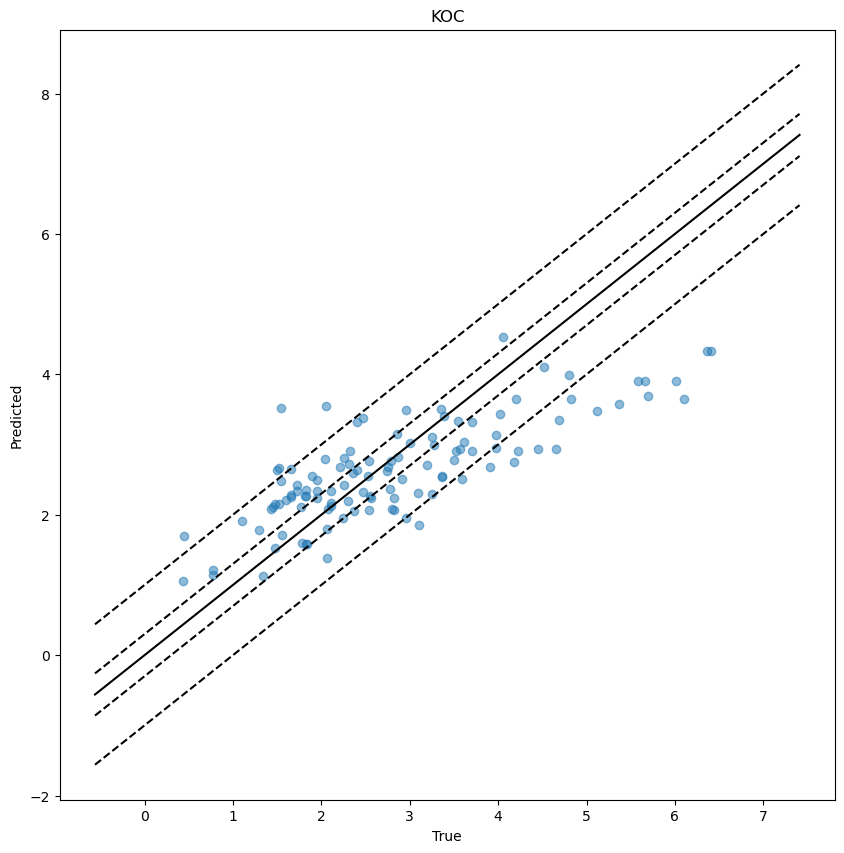

Property: MP
kendall_tau: 0.37020910717289385
rmse_overall: 87.30549298743952
mae_overall: 69.23887814072596
within_03_overall: 0.002144388849177984
within_1_overall: 0.007147962830593281
R2: 0.23378070460934441
Pearson: 0.5233161117189921


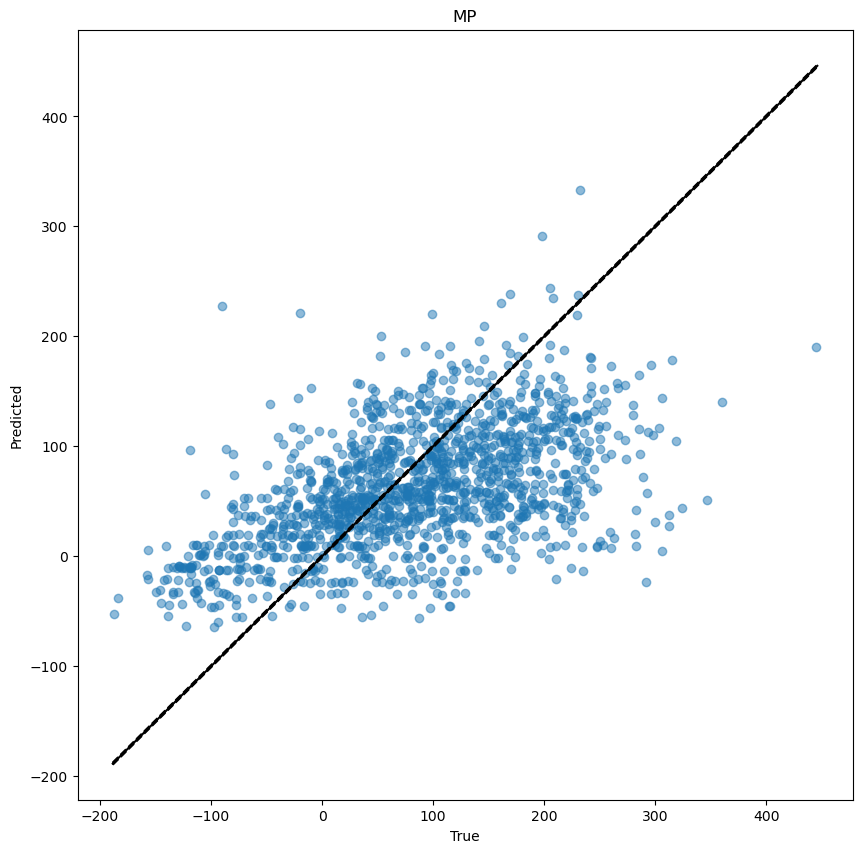

Property: RT
kendall_tau: 0.4152046783625731
rmse_overall: 6.598363725169153
mae_overall: 5.166463694552351
within_03_overall: 0.05263157894736842
within_1_overall: 0.21052631578947367
R2: 0.2696156115074716
Pearson: 0.525890042364062


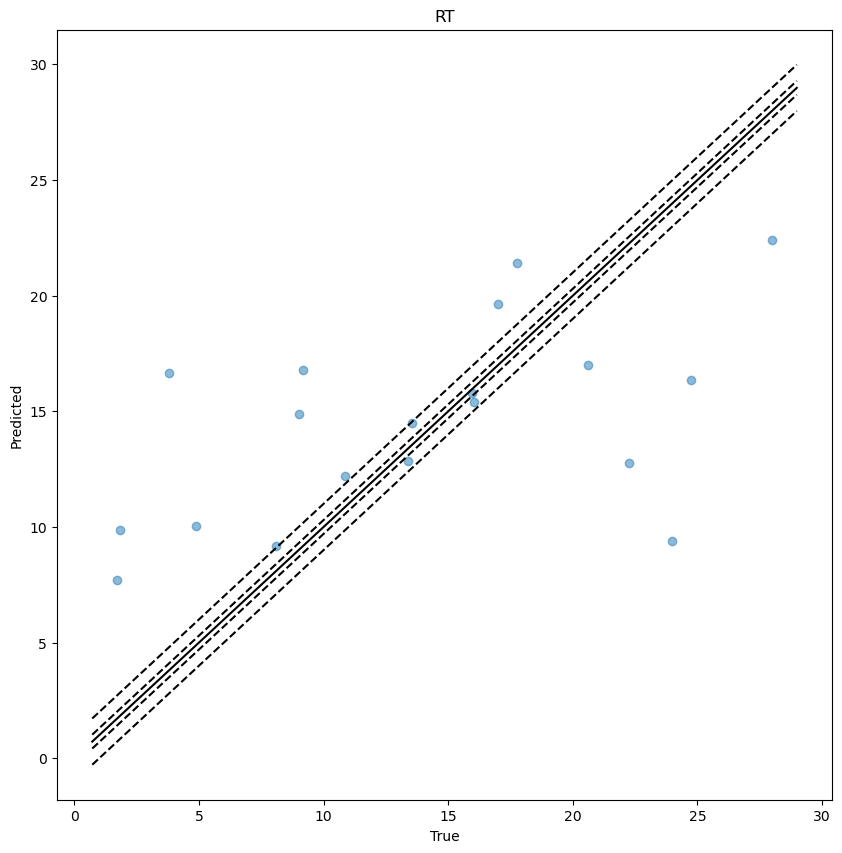

Property: WS
kendall_tau: 0.5291209053861511
rmse_overall: 1.5721877793464965
mae_overall: 1.1998587725997605
within_03_overall: 0.1670616113744076
within_1_overall: 0.5130331753554502
R2: 0.5365971723783276
Pearson: 0.7359774597261108


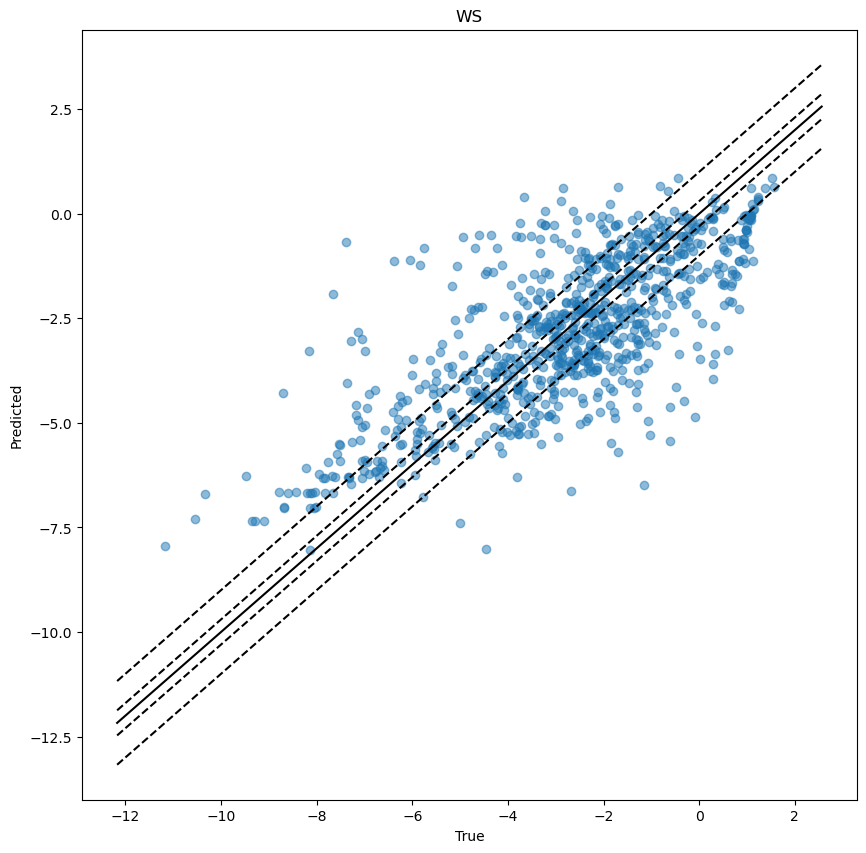

In [51]:
#plot and get stats for each property 
for prop in df_preds.columns:
    #make tmp df, where all nan are dropped for that property
    df_preds_tmp = df_preds[[prop]].dropna()
    df_ys_tmp = df_ys[[prop]].dropna()
    preds = df_preds_tmp[prop].values
    ys = df_ys_tmp[prop].values
    kendall_tau,rmse_overall,mae_overall,within_03_overall,within_1_overall = get_stats(preds,ys)
    r2 = r2_score(ys,preds)
    pearson = pearsonr(ys,preds)[0]
    print(f'Property: {prop}')
    print(f'kendall_tau: {kendall_tau}')
    print(f'rmse_overall: {rmse_overall}')
    print(f'mae_overall: {mae_overall}')
    print(f'within_03_overall: {within_03_overall}')
    print(f'within_1_overall: {within_1_overall}')
    print(f'R2: {r2}')
    print(f'Pearson: {pearson}')
    plt.figure(figsize=(10, 10))
    plt.scatter(ys, preds, alpha=0.5)
    min_val = min(min(ys),min(preds))
    max_val = max(max(ys),max(preds))
    #add diagonal, and lines at +- 0.3 and +- 1
    plt.plot([min_val-1,max_val+1],[min_val-1,max_val+1],color='black')
    plt.plot([min_val-1,max_val+1],[min_val-1+0.3,max_val+1+0.3],color='black',linestyle='--')
    plt.plot([min_val-1,max_val+1],[min_val-1-0.3,max_val+1-0.3],color='black',linestyle='--')
    plt.plot([min_val-1,max_val+1],[min_val-1+1,max_val+1+1],color='black',linestyle='--')
    plt.plot([min_val-1,max_val+1],[min_val-1-1,max_val+1-1],color='black',linestyle='--')
    plt.xlabel('True')
    plt.ylabel('Predicted')
    plt.title(prop)
    plt.show()

In [105]:
df_preds = pd.DataFrame(preds).T
df_ys = pd.DataFrame(ys).T
#rename columns
df_preds.columns = df.columns[1:]
df_ys.columns = df.columns[1:]
#rescale using the scaler
# df_preds = scaler.inverse_transform(df_preds)
# df_ys = scaler.inverse_transform(df_ys)
df_preds

,logP,logVP,logOH,logBCF,Biodeg,BP,Clint,FU,HL,KM,KOA,KOC,MP,RT,WS
0,0.572456,0.211647,0.894877,0.308149,0.487345,0.814993,0.780409,0.080025,0.262844,0.225770,0.969607,0.598131,0.493021,0.510980,0.492920
1,0.635882,0.599757,0.801181,0.458415,0.215910,0.467203,0.812272,0.160414,0.813907,0.475505,0.455957,0.471651,0.182614,0.411073,0.523759
2,0.330326,0.527124,0.796771,0.135709,0.113380,0.513212,0.603922,0.678440,0.434414,0.039099,0.420919,0.201865,0.382036,0.012023,0.817397
3,0.462476,0.427746,0.564079,0.305132,0.241864,0.620390,0.605375,0.155977,0.476828,0.340178,0.610695,0.383242,0.418408,0.191812,0.646414
4,0.585502,0.308024,0.914287,0.370603,0.442161,0.744663,0.806136,0.091175,0.418804,0.304450,0.846590,0.549928,0.422617,0.501074,0.531524
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4646,0.597567,0.327284,0.792889,0.466609,0.370239,0.772295,NaN,0.718200,0.510126,0.401231,0.783441,0.575536,0.494286,0.411317,0.501704
4647,0.316089,0.386142,0.837481,0.116812,0.125881,0.639578,NaN,0.228814,0.269014,0.019329,0.554430,0.205536,0.428317,0.035158,0.784895
4648,0.425163,0.322397,0.648524,0.193532,0.154496,0.676845,NaN,0.342471,0.304984,0.197527,0.716064,0.327337,0.173083,0.223799,0.655306
4649,0.535236,0.664677,0.736732,0.353299,0.071884,0.443339,NaN,0.422307,0.824102,0.375885,0.456681,0.379150,0.285467,0.299178,0.662704


To do:
1. Add the different endpoints - check
2. Normalization of values
3. Weighting of the tasks
4. Hyperparameter optimization
5. Benchmarking datasets? E.g. SAMPL7 for logP
6. Quadruple check refs - check
7. Think about datasplitting: same splits as OPERA? possible? otherwise, just cross-val? or random splits (multiple)
8. Different random weight initializations of the model


split: 80/20 5x

HP OPT: https://docs.ray.io/en/latest/tune/api/doc/ray.tune.search.bayesopt.BayesOptSearch.html
Repeated K-fold: https://greglandrum.github.io/rdkit-blog/posts/2023-08-13-xval-variability1.html